In [2]:
import numpy as np
import matplotlib.pyplot as plt
from inktime import rgbkm
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import cv2

In [4]:
def sobel_gradient(img_rgb, ksize=3, sigma=0.5):
    """
    Proper vector-valued LAB Sobel gradient.

    Returns
    -------
    magnitude : float32 (H,W)  -- NOT normalized
    gx        : float32 (H,W)
    gy        : float32 (H,W)
    """

    lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB).astype(np.float32)
    lab = cv2.GaussianBlur(lab, (0, 0), sigma)

    gx2 = np.zeros(lab.shape[:2], dtype=np.float32)
    gy2 = np.zeros(lab.shape[:2], dtype=np.float32)

    for c in range(3):
        gx_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 1, 0, ksize=ksize)
        gy_c = cv2.Sobel(lab[:, :, c], cv2.CV_32F, 0, 1, ksize=ksize)

        gx2 += gx_c**2
        gy2 += gy_c**2

    gx = np.sqrt(gx2)
    gy = np.sqrt(gy2)

    magnitude = np.sqrt(gx2 + gy2)

    return magnitude, gx, gy

In [6]:
def preprocessing(img, sigma_c = 20, sigma_s = 8, d =20):
    """Increases contrast using CLAHE and removes noise with bilateralFilter"""

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, a, b = cv2.split(lab)
    
    # Bilateral filtering on L channel
    L_filtered = cv2.bilateralFilter(
        L,
        d= d,               # neighborhood diameter
        sigmaColor=sigma_c,     # range sigma (intensity)
        sigmaSpace=sigma_s       # spatial sigma
    )
    
    # Recombine
    lab_filtered = cv2.merge((L_filtered, a, b))
    result = cv2.cvtColor(lab_filtered, cv2.COLOR_LAB2BGR)
    
    return result

## Load in Fuji

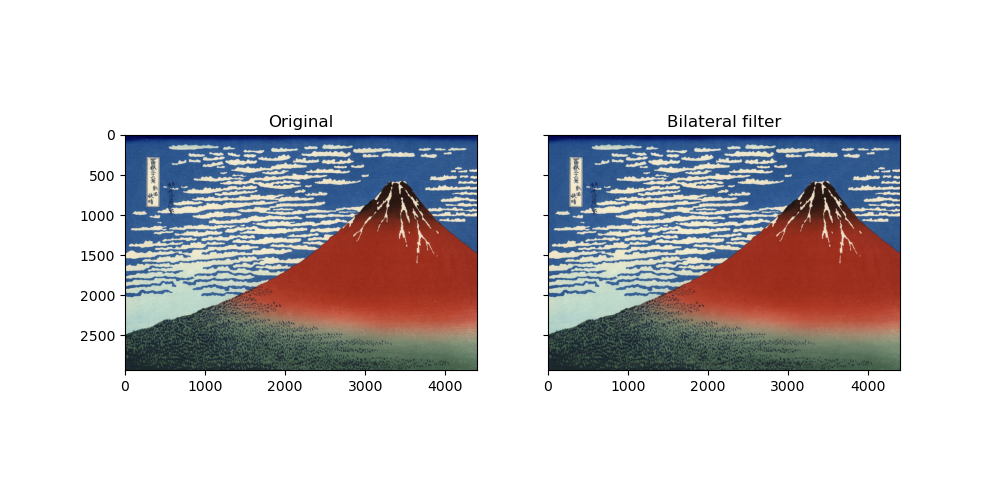

In [9]:
%matplotlib widget

img = cv2.imread('red_fuji3.jpg') # high res
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

h, w, _ = img.shape
processed_img = preprocessing(img)


# Convert to LAB 
img_lab = cv2.cvtColor(processed_img, cv2.COLOR_RGB2LAB)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title("Original")
ax[0].imshow(img)
ax[1].set_title("Bilateral filter")
ax[1].imshow(processed_img)
plt.show()


## Color segmentation

#### SLICO super pixels then DBSCAN/OPTICS
Does not work because the super pixels result in too much loss of detail

In [ ]:
from skimage.segmentation import slic

# Compute SLIC superpixels
segments = slic(img, n_segments=1500, compactness=0.01, start_label=0, slic_zero=True)

num_segments = segments.max() + 1

In [ ]:
plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5))
ax[0].imshow(segments, cmap = 'flag')
ax[1].imshow(img)
ax[1].contour(segments, colors='lime', linewidths=0.5)
plt.show()

In [ ]:
median_colors = np.zeros((num_segments, 3))

for label in range(num_segments):
    mask = segments == label
    median_colors[label] = np.median(img_lab[mask], axis=0)

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=8,min_samples=5)

cluster_labels = db.fit_predict(median_colors)

In [ ]:
clustered_image = np.zeros_like(img)

for seg_label in range(num_segments):
    cluster_id = cluster_labels[seg_label]
    mask = segments == seg_label

    if cluster_id == -1:
        clustered_image[mask] = [0, 0, 0]  # optional noise color
    else:
        clustered_image[mask] = img[mask].mean(axis=0)

In [ ]:
plt.close()
plt.imshow(clustered_image)
plt.show()

#### Overcluster then merge

In [11]:
from sklearn.cluster import MiniBatchKMeans

def over_cluster(img_lab, k_initial = 30, batch_size = 10000, random_state = 42, n_init = 10):
    pixels = img_lab.reshape(-1, 3)
    k_initial = 30  # overspecify

    # Mini Batch K-means: takes a random subset and performs k-means
    kmeans = MiniBatchKMeans(
        n_clusters=k_initial,
        batch_size=batch_size,
        random_state=random_state,
        n_init=n_init
    )

    labels = kmeans.fit_predict(pixels) # labels shape (HxW)
    centroids = np.array(kmeans.cluster_centers_)  # color centers (k)

    segmented_lab = centroids[labels]
    segmented_lab = segmented_lab.reshape(h, w, 3).astype(np.uint8)
    return centroids, labels, segmented_lab

centroids, labels, segmented_lab =  over_cluster(img_lab)
    

In [13]:
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import connected_components

def merge_close_colors(img_lab, centroids, labels, merge_threshold = 18):
    
    # Compute centroid distances
    dist_matrix = cdist(centroids, centroids)
    
    # Build adjacency matrix
    adj_matrix = dist_matrix < merge_threshold
    np.fill_diagonal(adj_matrix, False)  # remove self-connections
    
    # Connected components (cluster merging)
    n_components, component_labels = connected_components(adj_matrix, directed=False)
    
    print(f"Initial clusters: {len(centroids)}")
    print(f"Final merged clusters: {n_components}")
    
    # Relabel pixels
    final_labels = component_labels[labels]
    
    # Compute final centroids
    final_centroids = np.zeros((n_components, 3))
    pixels = img_lab.reshape(-1,3)
    
    for comp in range(n_components):
       mask = final_labels == comp
       final_centroids[comp] = pixels[mask].mean(axis=0)

    final_centroids = np.array(final_centroids)

    segmented_lab = final_centroids[final_labels]
    segmented_lab = segmented_lab.reshape(h, w, 3).astype(np.uint8)
    
    return final_centroids, final_labels , segmented_lab

final_centroids, final_labels, segmented_lab2 = merge_close_colors(img_lab, centroids, labels)

Initial clusters: 30
Final merged clusters: 13


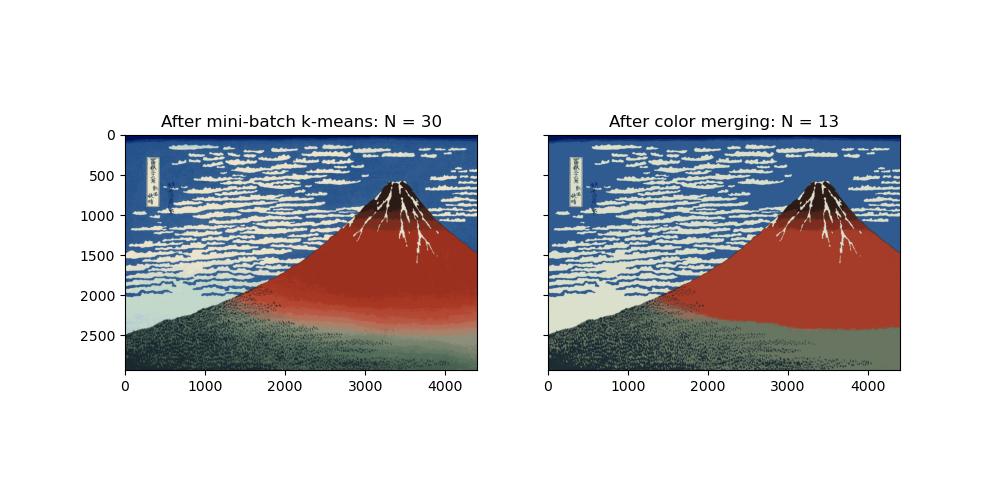

In [15]:
segmented_rgb = cv2.cvtColor(segmented_lab, cv2.COLOR_LAB2RGB)
segmented_rgb2 = cv2.cvtColor(segmented_lab2, cv2.COLOR_LAB2RGB)

plt.close()
fig, ax = plt.subplots(1,2, figsize = (10,5), sharex = True, sharey = True)
ax[0].set_title(f"After mini-batch k-means: N = {len(centroids)}")
ax[0].imshow(segmented_rgb)
ax[1].set_title(f"After color merging: N = {len(final_centroids)}")
ax[1].imshow(segmented_rgb2)
plt.show()

Number of regions after merging: 13


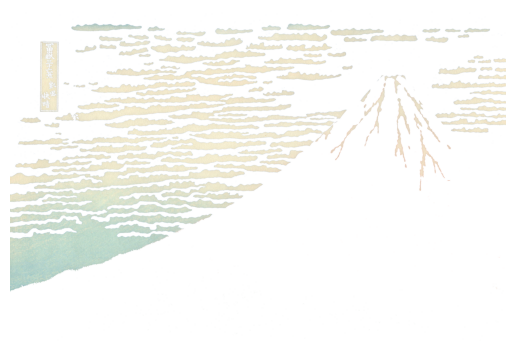

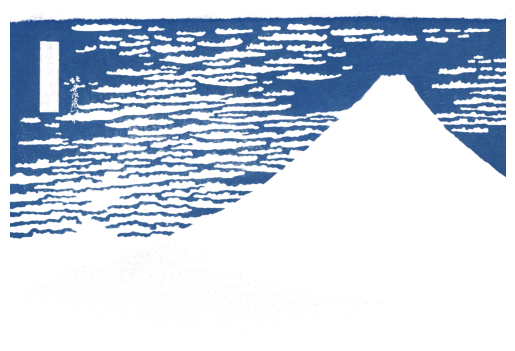

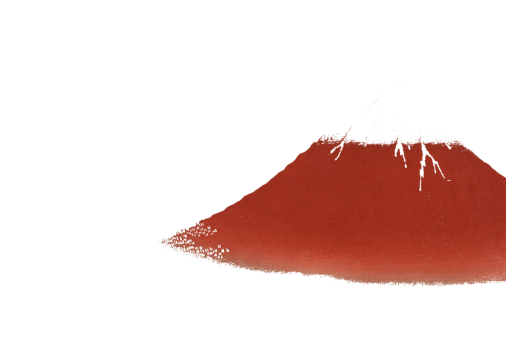

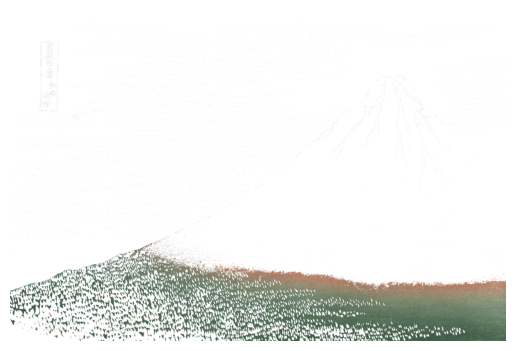

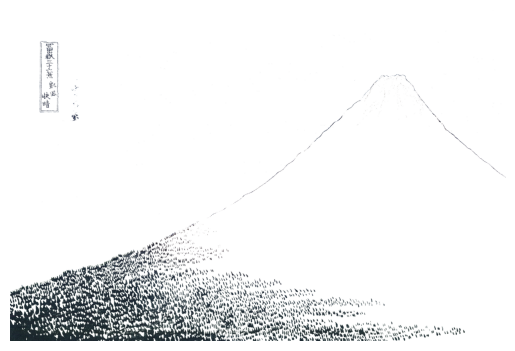

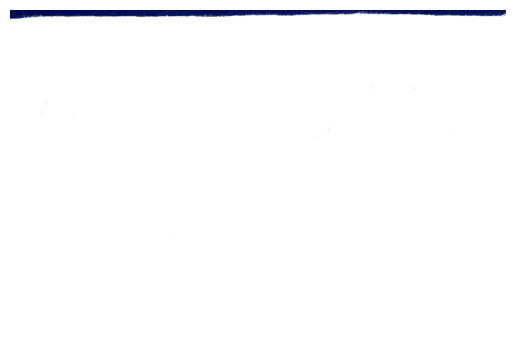

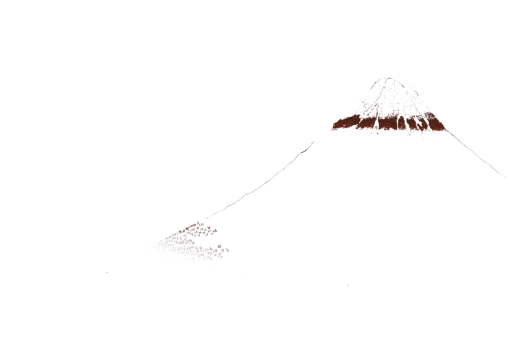

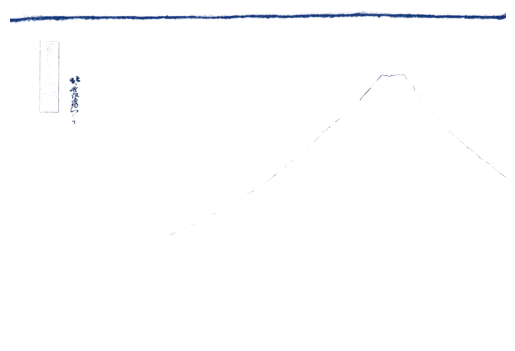

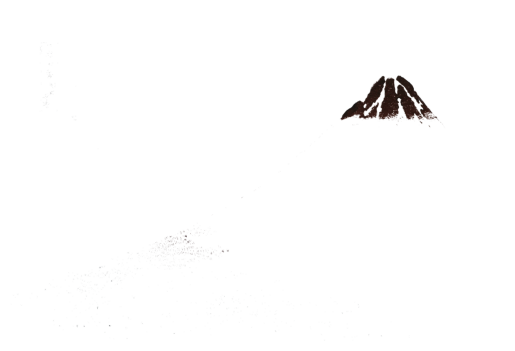

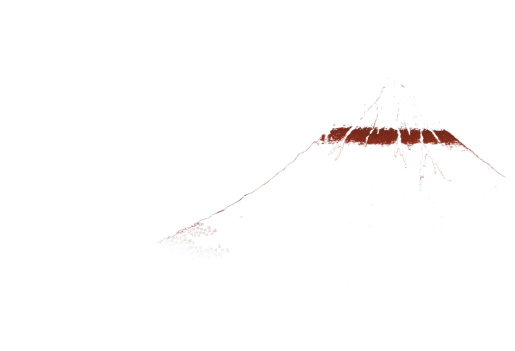

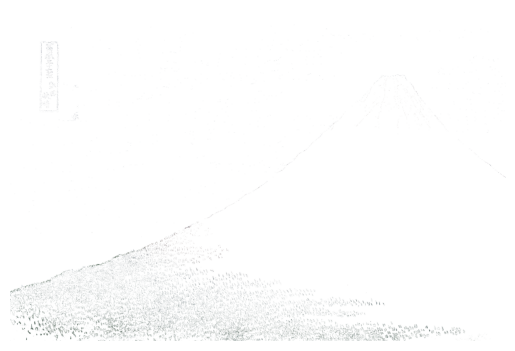

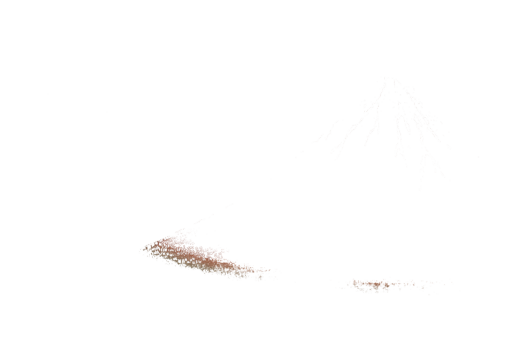

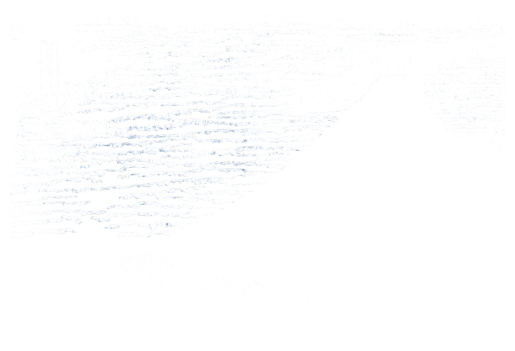

In [18]:
%matplotlib inline

final_labels = final_labels.reshape(h,w)
labels_unique = np.unique(final_labels)
print('Number of regions after merging:', len(labels_unique))

for label in labels_unique:
    mask = (final_labels == label)

    # Create white canvas
    white_bg = np.ones_like(img) * 255  # 255 = white for uint8

    # Copy original pixels where mask is True
    white_bg[mask] = img[mask]

    plt.imshow(white_bg)
    plt.axis('off')
    plt.show()

## Spatial segmentation: merge based on gradient

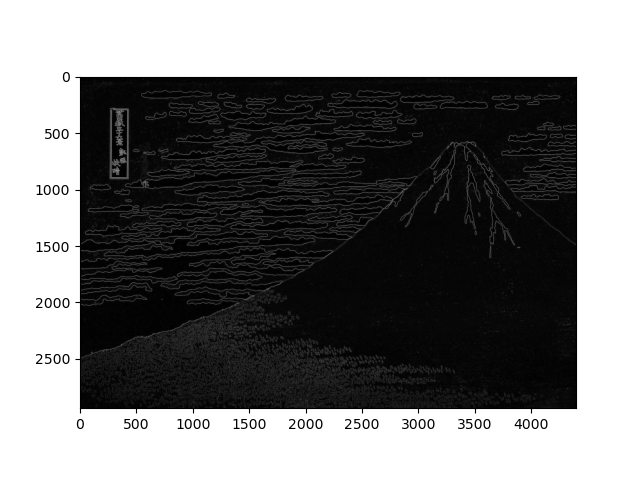

In [20]:
%matplotlib widget
magnitude, gx, gy = sobel_gradient(img_lab)

plt.close()
plt.imshow(magnitude, cmap = 'gray')
plt.show()

#### TRY I

In [ ]:
final_labels = final_labels.reshape(h,w)

# --- ONLY DETECTS EXISTENCE OF CONTACT

# Store adjacent pairs (pixels from different components that are neighbors)
adj_pairs = set() # set ensures no duplicates

# Check right and bottom neighbors (avoid duplicates)
for y in range(h - 1):
    for x in range(w - 1):
        a = final_labels[y, x]
        b = final_labels[y, x + 1] # right
        c = final_labels[y + 1, x] # bottom

        # Store if neighboring pixels are of different cluster ONLY ONCE
        if a != b:
            adj_pairs.add(tuple(sorted((a, b)))) # sorted ensures no duplicates
        if a != c:
            adj_pairs.add(tuple(sorted((a, c))))

merge_threshold = 0.052  # tune based on gradient scale

merge_graph = []

for (a, b) in adj_pairs:
    
    # Boundary mask: pixels where a touches b
    boundary_mask = (
        ((final_labels == a) & 
         (np.roll(final_labels, -1, axis=1) == b)) | # Pixel (y, x) is compared with (y, x+1) RIGHT
        ((final_labels == a) &  
         (np.roll(final_labels, -1, axis=0) == b)) # Pixel (y, x) is compared with (y+1, x) BOTTOM
    )

    if np.any(boundary_mask): # ensure no empty mask
        mean_grad = mag[boundary_mask].mean() # mean gradient value in boundary mask
        
        if mean_grad < merge_threshold: # store in merge_graph if clusters should merge
            merge_graph.append((a, b))

from scipy.sparse import lil_matrix
from scipy.sparse.csgraph import connected_components


n_clusters = final_labels.max() + 1

graph = lil_matrix((n_clusters, n_clusters), dtype=np.uint8)

# merge clusters
for (a, b) in merge_graph:
    graph[a, b] = 1
    graph[b, a] = 1

n_components, component_labels = connected_components(graph, directed=False)
merged_labels = component_labels[final_labels]

In [ ]:
%matplotlib inline
merged_labels = merged_labels.reshape(h,w)
n_components = merged_labels.max() + 1

# Compute centroid LAB per component
centroids_lab = np.zeros((n_components, 3), dtype=np.float64)

for comp in range(n_components):
    mask = merged_labels == comp
    centroids_lab[comp] = img_lab[mask].mean(axis=0)

# Refill image with centroid colors
segmented_lab = centroids_lab[merged_labels]

segmented_lab = segmented_lab.astype(np.uint8)

# Convert back to RGB for display
segmented_rgb = cv2.cvtColor(segmented_lab, cv2.COLOR_LAB2RGB)

# Plot
plt.figure(figsize=(8,8))
plt.imshow(segmented_rgb)
plt.axis("off")
plt.title(f"Merged Clusters: {n_components}")
plt.show()

In [ ]:
merged_labels_unique = np.unique(merged_labels)
#print('Number of regions after merging:', len(cluster_ids))

for label in merged_labels_unique:
    mask = (merged_labels == label)

    plt.imshow(img * mask[:,:,None])
    plt.axis('off')
    plt.show()

#### TRY II: 8-way connectivity

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components

# 8 based connectivity
def gradient_spatial_merge(labels, mag, merge_threshold=0.05):
    """
    Merge labeled regions if the mean gradient along their 8-connected boundary
    is below a threshold.

    Parameters
    ----------
    labels : np.ndarray (H, W)
        Initial cluster labels (integers starting from 0 or any non-negative int).
    mag : np.ndarray (H, W)
        Gradient magnitude image (same shape as labels).
    merge_threshold : float
        Regions are merged if mean boundary gradient < threshold.

    Returns
    -------
    merged_labels : np.ndarray (H, W)
        Relabeled image after gradient-based spatial merging.
    """

    #-----------------------------------
    # 1. PREPARE LABELS
    #------------------------------------
    labels = labels.astype(np.int32)
    H, W = labels.shape
    
    # Ensure labels are compact (0..N-1)
    unique_labels, relabeled = np.unique(labels, return_inverse=True) # unique labels + indices 
    labels = relabeled.reshape(H, W) 
    n_labels = len(unique_labels)

    #----------------------------------------------
    # 2. IDENTIFY BOUNDARY PIXELS (8-WAY CONNECTIVITY)
    #-----------------------------------------------
    # 8-connectivity shifts (only forward directions to avoid duplicates)
    shifts = [
        (0, 1),   # right
        (1, 0),   # down
        (1, 1),   # down-right
        (1, -1),  # down-left
    ]

    # Each index i corresponds to one boundary pixel
    edges_a = [] # label of region A
    edges_b = [] # label of region B
    edge_weights = [] # gradient value boundary pixel

    for dy, dx in shifts:

        # Define valid slicing for every shift
        y1 = slice(None)
        y2 = slice(None)
        x1 = slice(None)
        x2 = slice(None)

        if dy == 1: # down
            y1 = slice(1, None) # remove first row
            y2 = slice(0, -1) # remove last row
        if dx == 1: # right
            x1 = slice(1, None) # remove first column
            x2 = slice(0, -1) # remove last column
        if dx == -1: # left
            x1 = slice(0, -1)  # remove last column
            x2 = slice(1, None) # remove first column

        L1 = labels[y1, x1] # current pixels
        L2 = labels[y2, x2] # shifted pixels
        G  = mag[y1, x1] # gradient values at current pixels

        # True if label value does not match: boundaries in current direction/shift
        mask = L1 != L2 
        if not np.any(mask):
            continue

        # Select boundaries
        a = L1[mask] # current
        b = L2[mask] # shifted
        g = G[mask]  # gradient values in boundary

        # Sort pairs to avoid directional duplicates: ensures right order
        pairs = np.stack([np.minimum(a, b), np.maximum(a, b)], axis=1)

        # Arrays of all region pairs that touch: which two clusters (A, B) touch at boundary pixel i?
        edges_a.append(pairs[:, 0]) 
        edges_b.append(pairs[:, 1]) 
        edge_weights.append(g) # gradient value at pixel i
        
    # do nothing if no cluster edges are found
    if len(edges_a) == 0:
        return labels.copy()
        
    # convert to single arrays
    edges_a = np.concatenate(edges_a)
    edges_b = np.concatenate(edges_b)
    edge_weights = np.concatenate(edge_weights)

    #-----------------------------------
    # 3. IDENTIFY WEAK BOUNDARIES
    #------------------------------------

    # Create unique integer for every region pair that touches
    pair_ids = edges_a * n_labels + edges_b 

    #unique_pairs: array containing all unique label pairs
    #inv: is an index array that tells us, for each boundary pixel, which unique pair it belongs to
    unique_pairs, inv = np.unique(pair_ids, return_inverse=True) 

    # Calculate mean gradient in boundary:
    sum_grad = np.bincount(inv, weights=edge_weights) # Sum gradient values per boundary
    count = np.bincount(inv) # total amount of pixels in boundary
    mean_grad = sum_grad / count # mean gradient in boundary

    mean_grad /= (mean_grad.max() + 1e-8)

    # Select weak boundaries
    weak = mean_grad < merge_threshold

    # Keep regions seperated if boundaries are strong
    if not np.any(weak):
        return labels.copy()

    # select touching regions with weak boundary
    selected_pairs = unique_pairs[weak]

    #-----------------------------------
    # 4. MERGE WEAK BOUNDARIES
    #------------------------------------
    
    # convert integer back to region labels
    a = selected_pairs // n_labels 
    b = selected_pairs % n_labels

    # Build sparse adjacency matrix of region labels that should merge (symmetric)
    row = np.concatenate([a, b])
    col = np.concatenate([b, a])
    data = np.ones(len(row), dtype=np.uint8)

    graph = coo_matrix((data, (row, col)), shape=(n_labels, n_labels))

    # Connected components = merged regions
    _, component_labels = connected_components(graph, directed=False)

    merged_labels = component_labels[labels]

    return merged_labels

In [ ]:
merged_labels = gradient_spatial_merge(final_labels.reshape(h,w), mag, merge_threshold = 0.10)

In [ ]:
%matplotlib inline
merged_labels_unique = np.unique(merged_labels)
print('Number of regions after merging:', len(merged_labels_unique))

for label in merged_labels_unique:
    mask = (merged_labels == label)

    plt.imshow(img * mask[:,:,None])
    plt.axis('off')
    plt.show()

#### Explanation/visualization working of 8-connectivity function

In [ ]:
# Small example label image
labels = np.array([
    [0, 0, 1, 1, 1],
    [0, 0, 1, 2, 2],
    [3, 3, 1, 2, 2],
    [3, 3, 3, 2, 2],
    [3, 3, 3, 4, 4]
])

H, W = labels.shape

# Show clusters
plt.figure(figsize=(5,5))
plt.title("Clusters")
plt.imshow(labels)
plt.show()


shifts = [(0,1),(1,0),(1,1),(1,-1)]
boundary_pixels = []

for dy, dx in shifts:
    print(dx, dy)
    print('-------------------------------------------------')
    y1 = slice(None)
    y2 = slice(None)
    x1 = slice(None)
    x2 = slice(None)

    if dy == 1: # Selects "down neighbors"
        print('down')
        y1 = slice(1,None) # remove first column
        y2 = slice(0,-1) # remove last column
    if dx == 1: # Selects "right neighbors"
        print('right')
        x1 = slice(1,None) # remove first row
        x2 = slice(0,-1) # remove last row
    if dx == -1: # Selects "down and left neighbors"
        print('left')
        x1 = slice(0,-1) # remove last row
        x2 = slice(1,None) # remove first row

    L1 = labels[y1, x1] 
    L2 = labels[y2, x2]
    mask = L1 != L2 # true if label value does not match

    fig, ax = plt.subplots(1,3, figsize = (10,5), sharex = True, sharey = True)

    ax[0].set_title("L1")
    ax[0].imshow(L1)
    ax[1].set_title("L2")
    ax[1].imshow(L2)
    ax[2].set_title("neighbors")
    ax[2].imshow(mask)
    plt.show()
    
    coords = np.stack(np.where(mask), axis=1) # coordinates of pixels where mask = 1: boundary pixels
    
    # Shift coords back to image coordinates: enlarge image in appropriate way
    coords[:,0] += y1.start or 0
    coords[:,1] += x1.start or 0
    boundary_pixels.append(coords)

boundary_pixels = np.concatenate(boundary_pixels)

#### TRY III: include gradient coherence

In [22]:
from scipy.sparse import coo_matrix
from scipy.sparse.csgraph import connected_components

def gradient_spatial_merge(labels, mag, gx, gy,
                           merge_threshold=0.05,
                           coherence_threshold=0.7):
    """
    Merge labeled regions if:
        mean boundary gradient < merge_threshold
        AND
        gradient coherence < coherence_threshold

    Parameters
    ----------
    labels : (H, W) int
    mag    : (H, W) float   gradient magnitude (normalized)
    gx     : (H, W) float   x-gradient
    gy     : (H, W) float   y-gradient
    merge_threshold : float
    coherence_threshold : float

    Returns
    -------
    merged_labels : (H, W) int
    """

    # -----------------------------------
    # 1. PREPARE LABELS
    # -----------------------------------
    labels = labels.astype(np.int32)
    H, W = labels.shape

    unique_labels, relabeled = np.unique(labels, return_inverse=True)
    labels = relabeled.reshape(H, W)
    n_labels = len(unique_labels)

    # -----------------------------------
    # 2. IDENTIFY BOUNDARY PIXELS (8-CONNECTED)
    # -----------------------------------
    shifts = [
        (0, 1),
        (1, 0),
        (1, 1),
        (1, -1),
    ]

    edges_a = []
    edges_b = []
    edge_weights = []
    edge_gx = []
    edge_gy = []

    for dy, dx in shifts:

        y1 = slice(None)
        y2 = slice(None)
        x1 = slice(None)
        x2 = slice(None)

        if dy == 1:
            y1 = slice(1, None)
            y2 = slice(0, -1)
        if dx == 1:
            x1 = slice(1, None)
            x2 = slice(0, -1)
        if dx == -1:
            x1 = slice(0, -1)
            x2 = slice(1, None)

        L1 = labels[y1, x1]
        L2 = labels[y2, x2]

        G  = mag[y1, x1]
        GX = gx[y1, x1]
        GY = gy[y1, x1]

        mask = L1 != L2
        if not np.any(mask):
            continue

        a = L1[mask]
        b = L2[mask]
        g = G[mask]
        gx_vals = GX[mask]
        gy_vals = GY[mask]

        pairs = np.stack([np.minimum(a, b), np.maximum(a, b)], axis=1)

        edges_a.append(pairs[:, 0])
        edges_b.append(pairs[:, 1])
        edge_weights.append(g)
        edge_gx.append(gx_vals)
        edge_gy.append(gy_vals)

    if len(edges_a) == 0:
        return labels.copy()

    edges_a = np.concatenate(edges_a)
    edges_b = np.concatenate(edges_b)
    edge_weights = np.concatenate(edge_weights)
    edge_gx = np.concatenate(edge_gx)
    edge_gy = np.concatenate(edge_gy)

    # -----------------------------------
    # 3. COMPUTE BOUNDARY STATISTICS
    # -----------------------------------

    pair_ids = edges_a * n_labels + edges_b
    unique_pairs, inv = np.unique(pair_ids, return_inverse=True)

    # raw magnitude per boundary pixel
    edge_mag = np.sqrt(edge_gx**2 + edge_gy**2)

    sum_gx = np.bincount(inv, weights=edge_gx)
    sum_gy = np.bincount(inv, weights=edge_gy)
    sum_mag = np.bincount(inv, weights=edge_mag)

    coherence = np.sqrt(sum_gx**2 + sum_gy**2) / (sum_mag + 1e-8)

    mean_grad = sum_mag / (np.bincount(inv) + 1e-8)
    mean_grad /= (mean_grad.max() + 1e-8)
    
    print("coherence min/max:", coherence.min(), coherence.max())
    print("mean_grad min/max:", mean_grad.min(), mean_grad.max())

    # -----------------------------------
    # 4. SELECT WEAK & NON-COHERENT BOUNDARIES
    # -----------------------------------

    weak = (mean_grad < merge_threshold) & \
           (coherence < coherence_threshold)

    if not np.any(weak):
        print('no weak edges')
        return labels.copy()

    selected_pairs = unique_pairs[weak]

    # -----------------------------------
    # 5. MERGE REGIONS
    # -----------------------------------

    a = selected_pairs // n_labels
    b = selected_pairs % n_labels

    row = np.concatenate([a, b])
    col = np.concatenate([b, a])
    data = np.ones(len(row), dtype=np.uint8)

    graph = coo_matrix((data, (row, col)), shape=(n_labels, n_labels))

    _, component_labels = connected_components(graph, directed=False)

    merged_labels = component_labels[labels]

    return merged_labels, final_centroids

In [24]:
merged_labels, centroids = gradient_spatial_merge(final_labels.reshape(h,w), magnitude, gx, gy, merge_threshold = 0.20, coherence_threshold = 0.93)

coherence min/max: 0.8373409141922168 1.0000000418507433
mean_grad min/max: 0.06682107771163787 0.9999999999560626


Number of regions after merging: 5
2711862


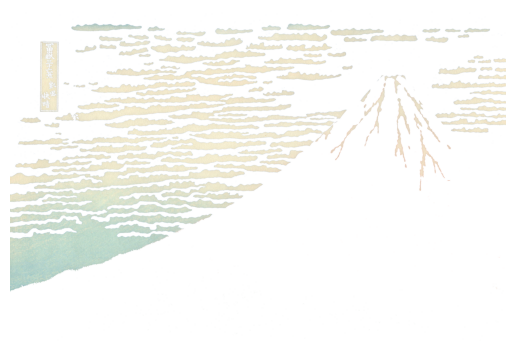

4178062


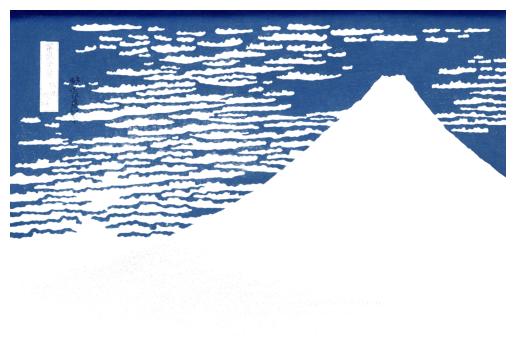

4907675


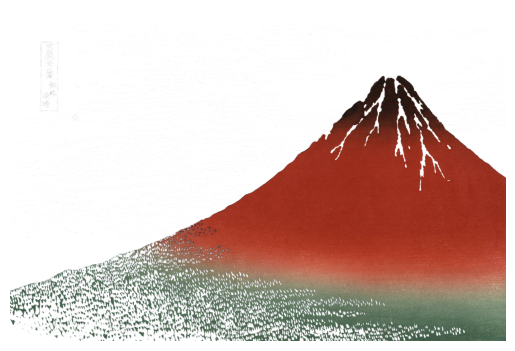

1011589


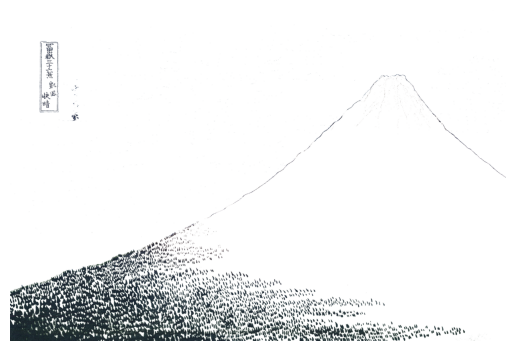

113612


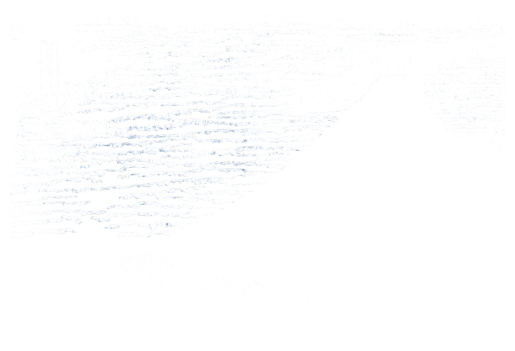

In [28]:
%matplotlib inline
merged_labels_unique = np.unique(merged_labels)
print('Number of regions after merging:', len(merged_labels_unique))

for label in merged_labels_unique:
    mask = (merged_labels == label)
    print(np.sum(mask))

    # Create white canvas
    white_bg = np.ones_like(img) * 255  # 255 = white for uint8

    # Copy original pixels where mask is True
    white_bg[mask] = img[mask]

    plt.imshow(white_bg)
    plt.axis('off')
    plt.show()

## Segmentation: merge based on spatial coherence

In [30]:
def merge_small_color_clusters(lab_image, labels, centroids, min_cluster_area=500000):
    """
    Merge small color clusters into nearest larger cluster (LAB space).

    Parameters:
        labels             : original label image
        clustered_labels   : 2D cluster ID image
        median_colors      : (num_regions, 3) LAB medians (aligned with unique labels)
        min_cluster_area   : minimum total pixel area for cluster to survive

    Returns:
        refined_clusters   : updated 2D cluster label image
    """

    refined = labels.copy()

    # Compute cluster pixel counts
    unique_labels, counts = np.unique(refined, return_counts=True)

    # Split large vs small
    large_clusters = unique_labels[counts >= min_cluster_area]
    small_clusters = unique_labels[counts < min_cluster_area]

    if len(small_clusters) == 0:
        return refined

    # Compute LAB centroid per cluster 
    unique_labels = np.unique(labels)

    # Reassign small clusters 
    for sc in small_clusters:

        sc_color = centroids[sc]

        # compute distances to large clusters
        distances = []
        for lc in large_clusters:
            lc_color = centroids[lc]
            d = np.linalg.norm(sc_color - lc_color)
            distances.append((d, lc))

        if len(distances) == 0:
            continue

        _, nearest_cluster = min(distances, key=lambda x: x[0])

        # reassign pixels
        refined[refined == sc] = nearest_cluster

    # ---- Compact labels ----
    new_unique = np.unique(refined)
    new_label_map = {old: new for new, old in enumerate(new_unique)}

    for old, new in new_label_map.items():
        refined[refined == old] = new

    # ---- Recompute centroids ----
    new_centroids = []
    for L in range(len(new_unique)):
        mask = (refined == L)
        new_centroids.append(lab_image[mask].mean(axis=0))

    new_centroids = np.array(new_centroids)

    return refined, new_centroids

In [32]:
refined_labels, new_centroids = merge_small_color_clusters(img_lab, merged_labels, centroids)

Number of regions after merging: 4
2711862


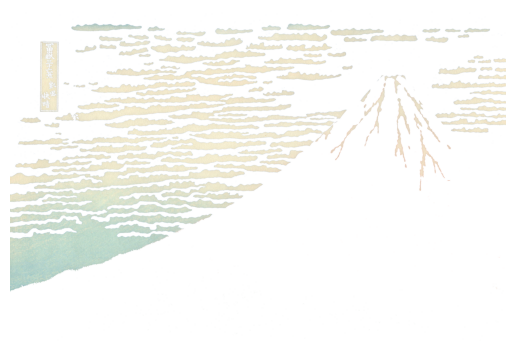

4291674


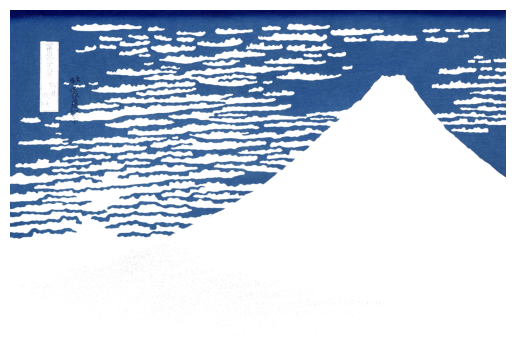

4907675


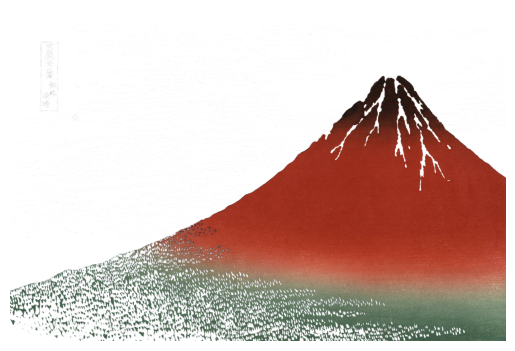

1011589


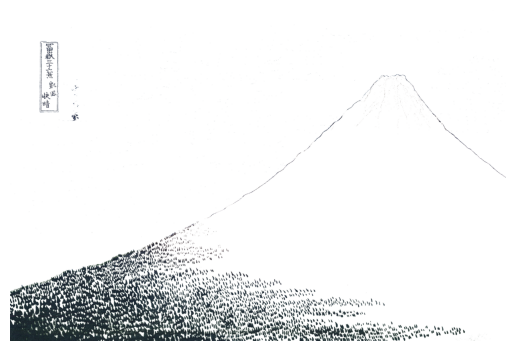

In [34]:
%matplotlib inline
refined_labels_unique = np.unique(refined_labels)
print('Number of regions after merging:', len(refined_labels_unique))

for label in refined_labels_unique:
    mask = (refined_labels == label)
    print(np.sum(mask))

    # Create white canvas
    white_bg = np.ones_like(img) * 255  # 255 = white for uint8

    # Copy original pixels where mask is True
    white_bg[mask] = img[mask]

    plt.imshow(white_bg)
    plt.axis('off')
    plt.show()

In [44]:
import numpy as np
from skimage.measure import label as cc_label
from scipy.ndimage import binary_dilation

def fully_vectorized_clean(labels, min_area_ratio_mask=0.01, connectivity=1):
    """
    Fully vectorized removal of small connected components in label masks.
    Small components are reassigned to the majority neighboring label.
    No Python loops over labels or components.

    Parameters
    ----------
    labels : (H,W) int
        Label image
    min_area_ratio_mask : float
        Minimum component area relative to each mask
    connectivity : int
        1=4-connectivity, 2=8-connectivity

    Returns
    -------
    cleaned_labels : (H,W) int
    """
    labels = labels.copy()
    H, W = labels.shape

    # Create structuring element
    structure = np.ones((3,3), dtype=bool) if connectivity==2 else np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=bool)

    # Step 1: assign a unique global component ID to all small components
    small_components = np.zeros_like(labels, dtype=int)
    component_counter = 1

    unique_labels = np.unique(labels)
    mask_sizes = {L: (labels==L).sum() for L in unique_labels}

    for L in unique_labels:
        mask = (labels==L)
        if mask.sum() == 0:
            continue
        cc = cc_label(mask, connectivity=connectivity)
        cc_ids, counts = np.unique(cc, return_counts=True)
        for comp_id, count in zip(cc_ids, counts):
            if comp_id==0:
                continue
            if count < mask_sizes[L]*min_area_ratio_mask:
                small_components[cc==comp_id] = component_counter
                component_counter += 1

    if component_counter==1:
        return labels  # no small components

    # Step 2: find neighbors of all small components using dilation
    dilated = binary_dilation(small_components>0, structure=structure)
    neighbor_mask = dilated & (small_components==0)
    neighbor_labels = labels[neighbor_mask]

    # Step 3: for each small component, assign majority neighbor label
    # build component -> neighbor mapping
    comp_ids = np.unique(small_components)
    comp_ids = comp_ids[comp_ids!=0]

    # compute majority neighbor label for each component
    # vectorized using bincount trick
    flattened = small_components.ravel()
    neighbors_flat = np.zeros_like(flattened)

    # pad labels to prevent indexing errors
    padded_labels = np.pad(labels, 1, mode='constant', constant_values=-1)
    padded_components = np.pad(small_components, 1, mode='constant', constant_values=0)

    offsets = [(-1,-1), (-1,0), (-1,1), (0,-1), (0,1), (1,-1), (1,0), (1,1)]
    # for each neighbor offset, accumulate neighbor labels of small components
    H_p, W_p = padded_labels.shape
    neighbor_data = []
    component_data = []

    ys, xs = np.nonzero(small_components>0)
    ys_p, xs_p = ys+1, xs+1  # padded coordinates

    for dy, dx in offsets:
        neighbor_vals = padded_labels[ys_p+dy, xs_p+dx]
        mask_valid = neighbor_vals != padded_labels[ys, xs]
        neighbor_vals = neighbor_vals[mask_valid]
        comp_ids_valid = small_components[ys[mask_valid], xs[mask_valid]]
        neighbor_data.append(neighbor_vals)
        component_data.append(comp_ids_valid)

    # concatenate
    neighbor_data = np.concatenate(neighbor_data)
    component_data = np.concatenate(component_data)

    # now for each component, find majority neighbor
    max_component = component_data.max()
    majority_labels = np.zeros(max_component+1, dtype=int)
    for comp_id in range(1, max_component+1):
        neighbors = neighbor_data[component_data==comp_id]
        if len(neighbors)==0:
            continue
        vals, counts = np.unique(neighbors, return_counts=True)
        majority_labels[comp_id] = vals[np.argmax(counts)]

    # assign majority labels to all small components
    mask_nonzero = small_components>0
    labels[mask_nonzero] = majority_labels[small_components[mask_nonzero]]

    return labels

In [46]:
cleaned_labels = fully_vectorized_clean(refined_labels)

Number of regions after merging: 5
62


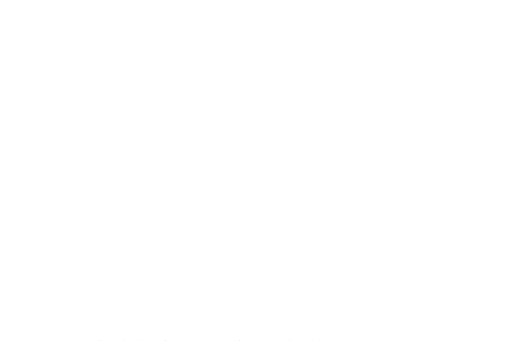

2701444


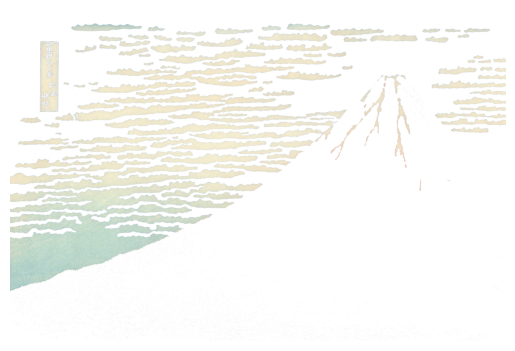

4294408


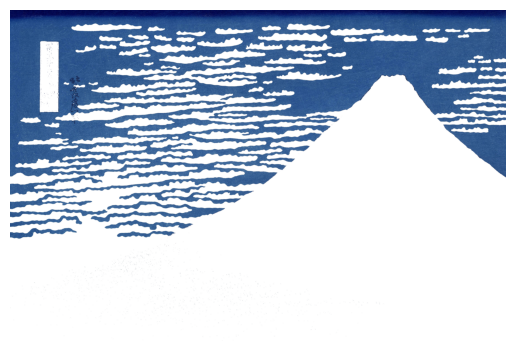

4983097


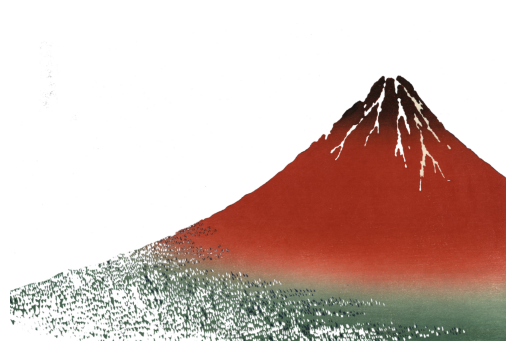

943789


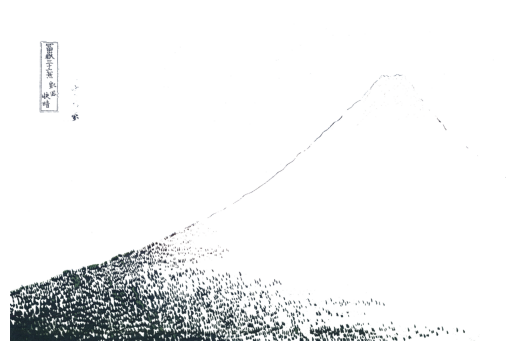

In [48]:
%matplotlib inline
cleaned_labels_unique = np.unique(cleaned_labels)
print('Number of regions after merging:', len(cleaned_labels_unique))

for label in cleaned_labels_unique:
    mask = (cleaned_labels == label)
    print(np.sum(mask))

    # Create white canvas
    white_bg = np.ones_like(img) * 255  # 255 = white for uint8

    # Copy original pixels where mask is True
    white_bg[mask] = img[mask]

    plt.imshow(white_bg)
    plt.axis('off')
    plt.show()